In [60]:
import boto3
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

In [61]:
"""
Transform input data for model
Lowercase all strings in the dataset
One-hot encode categorical columns such as Ethnicity and Gender
Return the one-hot encoder and combined numpy array
"""
def transform_input(df):
    df.applymap(lambda s: s.lower() if type(s) == str else s)
    df = df.drop(['Campus'], axis=1)
    
    # round gpas to the nearest hundreth
    df['GPA'] = [round(gpa, 2) for gpa in df['GPA']]
    
    # round sat scores to the nearest ten
    df['AvgScrRead'] = [round(score, -1) for score in df['AvgScrRead']]
    df['AvgScrMath'] = [round(score, -1) for score in df['AvgScrMath']]
    df['AvgScrWrit'] = [round(score, -1) for score in df['AvgScrWrit']]

    encoder = preprocessing.OneHotEncoder(handle_unknown='ignore')
    categorical_cols = ['Ethnicity', 'Gender', 'County']
    categorical = df[categorical_cols].values

    non_categorical_cols = ['GPA', 'AvgScrRead', 'AvgScrMath', 'AvgScrWrit']
    intermediate = df[non_categorical_cols]

    categoricl_transformed = encoder.fit_transform(categorical).toarray()
    features = np.hstack((intermediate.values, categoricl_transformed))

    return encoder, features

#### Read data

In [62]:
df = pd.read_csv('../data/applicant_admissions_data.csv')
df = df[df['Status'] == 1]

#### Look at some counts

In [128]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

def plot_barchart(x, y, y_labels, y_min, y_max, title, ylabel, xlabel, output):
    mpl.style.use('seaborn-white')
    fig, ax = plt.subplots()
    plt.bar(x, y)
    plt.xticks(x, y_labels)
    plt.ylim([y_min, y_max])
    plt.xticks(rotation=45)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.savefig(output)
    plt.show()
    

           Campus  Number of Admits
0        Berkeley               409
1           Davis               448
2          Irvine               409
3     Los Angeles               409
4          Merced               421
5       Riverside               409
6       San Diego               424
7   Santa Barbara               439
8      Santa Cruz               448
9  Universitywide               454


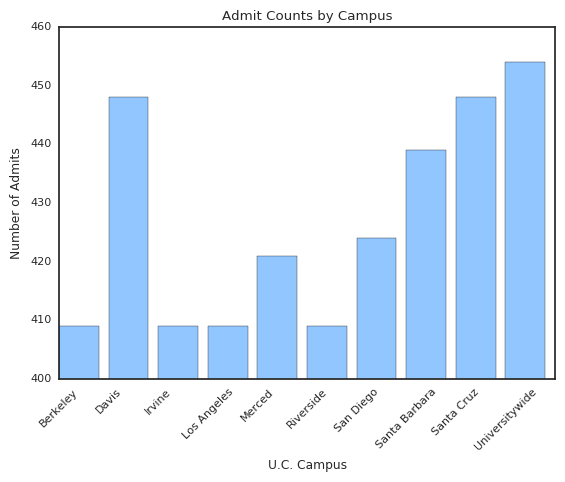

In [130]:
# how many admits per campus?
campus_counts = df.groupby('Campus') \
                    .count() \
                    .reset_index()[['Campus', 'County']] \
                    .rename(columns={'County': 'Number of Admits'})

print (campus_counts)
    
plot_barchart(range(0, 10), \
              campus_counts['Number of Admits'], \
              campus_counts['Campus'], \
              400, 460, \
              'Admit Counts by Campus',
              'Number of Admits',
              'U.C. Campus',
             'figures/admit_counts_by_campus.png')

In [64]:
# how many admits per county?
df.groupby('County') \
    .count() \
    .reset_index()[['Campus', 'County']] \
    .rename(columns={'Campus': 'Number of Admits'})

,Number of Admits,County
0,320,Alameda
1,150,Amador
2,320,Contra Costa
3,90,Humboldt
4,320,Los Angeles
5,48,Mendocino
6,150,Monterey
7,150,Napa
8,320,Orange
9,150,Sacramento


          Ethnicity  Number of Admits
0  African American               520
1               All               685
2   American Indian               272
3             Asian               652
4  Domestic Unknown               577
5  Hispanic/ Latino               649
6   Inter- national               260
7             White               655


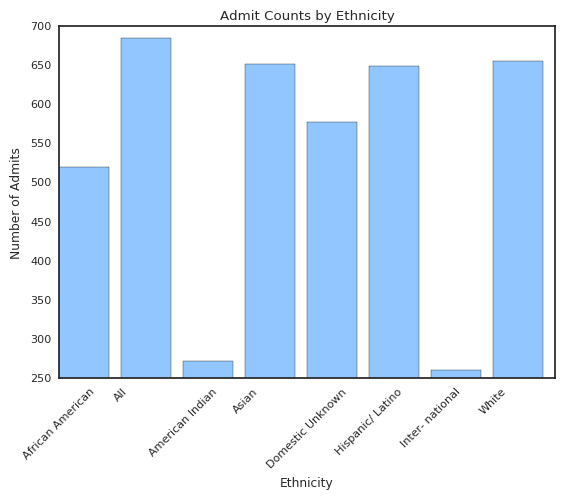

In [136]:
# how many admits per ethnicity?
ethnicity_counts = df.groupby('Ethnicity') \
                    .count() \
                    .reset_index()[['Ethnicity', 'County']] \
                    .rename(columns={'County': 'Number of Admits'})

print (ethnicity_counts)
    
plot_barchart(range(1, 9), \
              ethnicity_counts['Number of Admits'], \
              ethnicity_counts['Ethnicity'], \
              250, 700, \
              'Admit Counts by Ethnicity',
              'Number of Admits',
              'Ethnicity',
             'figures/ethnicity_counts_by_campus.png')

In [76]:
df.describe()

,GPA,AvgScrRead,AvgScrMath,AvgScrWrit
count,4270.000000,4270.000000,4270.000000,4270.000000
mean,3.910049,501.556909,512.386885,493.739110
std,0.199278,26.148170,29.346218,27.137035
min,3.508236,459.000000,457.000000,448.000000
25%,3.765366,477.000000,489.000000,470.000000
50%,3.928207,505.000000,514.000000,499.000000
75%,4.078026,517.000000,534.000000,511.000000
max,4.284815,548.000000,575.000000,549.000000


In [66]:
df = df.drop(['Unnamed: 0', 'Status'], axis=1)
df.head()

,County,Ethnicity,Gender,Campus,GPA,AvgScrRead,AvgScrMath,AvgScrWrit
0,San Bernardino,Domestic Unknown,Male,Berkeley,4.134665,462.0,470.0,453.0
1,San Bernardino,Domestic Unknown,Male,Davis,3.969556,462.0,470.0,453.0
2,San Bernardino,Domestic Unknown,Male,Irvine,3.966652,462.0,470.0,453.0
3,San Bernardino,Domestic Unknown,Male,Los Angeles,4.131310,462.0,470.0,453.0
4,San Bernardino,Domestic Unknown,Male,Merced,3.523493,462.0,470.0,453.0


#### Transform data

In [74]:
# transform the data for the model
# return the encoder as it is used in predictions
encoder, X = transform_input(df)

print ("X dimensions {0}".format(X.shape))

le = preprocessing.LabelEncoder()
y = le.fit_transform(df['Campus'])

print ("y dimensions {0}".format(y.shape))

# split data into 80% train 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1000)

print ("X train dimensions {0}".format(X_train.shape))
print ("y train dimensions {0}".format(y_train.shape))

X dimensions (4270, 39)
y dimensions (4270,)
X train dimensions (3202, 39)
y train dimensions (3202,)


#### Train the model

predicted dimensions (1068,)
y test dimensions (1068,)


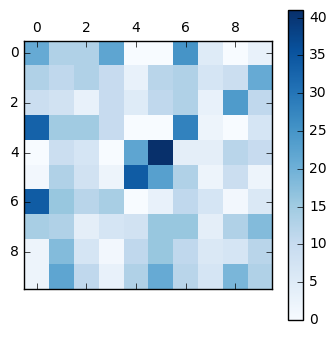

In [75]:
# train model
clf = LogisticRegression(
    random_state=0,
    solver='lbfgs',
    multi_class='multinomial',
    max_iter=500)

clf.fit(X_train, y_train)

# upload mode and encoder to AWS for prediction
pickle.dump(clf, open('models/gosat_logistic_regression', 'w'))
pickle.dump(encoder, open('models/gosat_logistic_encoder', 'w'))

# train model
clf = LogisticRegression(
    random_state=50,
    solver='lbfgs',
    multi_class='multinomial',
    max_iter=295)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print ("predicted dimensions {0}".format(y_pred.shape))
print ("y test dimensions {0}".format(y_test.shape))

cm = confusion_matrix(y_test, y_pred)

# Plot pixel ranking
plt.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

In [69]:
clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

#### Write data to Amazon S3

In [70]:
# upload mode and encoder to AWS for prediction
pickle.dump(clf, open('models/gosat_logistic_regression', 'w'))
pickle.dump(encoder, open('models/gosat_logistic_encoder', 'w'))

In [71]:
s3 = boto3.client('s3')
s3.upload_file('models/gosat_logistic_regression', 'gosat-models', 'gosat_logistic_regression')
s3.upload_file('models/gosat_logistic_encoder', 'gosat-models', 'gosat_logistic_encoder')

In [72]:
# output mapping of labels to universities
mapping = {}
for index, uni in zip(clf.classes_, le.inverse_transform(clf.classes_)):
    mapping[index] = uni

json.dump(mapping, open('models/label_mappings.json', 'w'))
s3.upload_file('models/label_mappings.json', 'gosat-models', 'gosat_label_mapping.json')